
### 1. Read & clean up data

Datasets is open-source and were taken from https://huggingface.co/datasets/arkodeep/jobdata (english vacancies) and https://www.kaggle.com/datasets/vyacheslavpanteleev1/hhru-it-vacancies-from-20211025-to-20211202 (russian vacancies)


#### 1. Read

We do not need all the data in the tables, so will throw out some (most) of the columns. Also it is good idea to combine datasets


In [14]:
import pandas as pd

data_en = pd.read_csv('vacancies-skills_datasets/jobs_all.csv')
data_ru = pd.read_csv('vacancies-skills_datasets/IT_vacancies_full.csv')

In [15]:
data_en.columns

Index(['job_title_short', 'job_title', 'job_location', 'job_via',
       'job_schedule_type', 'job_work_from_home', 'search_location',
       'job_posted_date', 'job_no_degree_mention', 'job_health_insurance',
       'job_country', 'salary_rate', 'salary_year_avg', 'salary_hour_avg',
       'company_name', 'job_skills', 'job_type_skills', 'key_id'],
      dtype='object')

In [16]:
data_ru.columns

Index(['Ids', 'Employer', 'Name', 'Salary', 'From', 'To', 'Experience',
       'Schedule', 'Keys', 'Description', 'Area', 'Professional roles',
       'Specializations', 'Profarea names', 'Published at'],
      dtype='object')

In [17]:
data_en = data_en[['job_title','job_skills']]
data_ru = data_ru[['Name','Keys']]

In [18]:
data_en.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."


In [19]:
data_ru.head()

,Name,Keys
0,Golang Developer (Кипр),"['Docker', 'Golang', 'Redis', 'Английский язык..."
1,Е-mail маркетолог,"['Грамотность', 'Написание текстов', 'Грамотна..."
2,Оператор call-центра (удаленно),"['Клиентоориентированность', 'Ориентация на ре..."
3,Ведущий SMM специалист,"['Продвижение бренда', 'Креативность', 'Adobe ..."
4,UX/UI Designer,"['UI', 'UX', 'gamedev', 'game design', 'проект..."


In [20]:
data_ru.rename(columns = {'Name': 'job_title', 'Keys': 'job_skills'}, inplace = True)

data_combined = pd.concat([data_en, data_ru], ignore_index=True)
data_combined.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."



#### 2. Clean up text

Transfer everything to the lower register, remove Nans and excess punctiation, convert skills into arrays etc

In [21]:
import re
import ast

data_combined = data_combined.dropna()
data_combined['job_skills'] = data_combined['job_skills'].apply(ast.literal_eval)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[-/()]', ' ', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9+#+.]', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_cell(cell):
    if isinstance(cell, list):
        return [clean_text(item) for item in cell if isinstance(item, str)]
    elif isinstance(cell, str):
        return clean_text(cell)
    else:
        return cell

for col in data_combined.columns:
    data_combined[col] = data_combined[col].apply(clean_cell)


In [22]:
data_combined.head(10)

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,..."
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr..."
8,technology operations business analyst,"[excel, powerpoint, power bi]"
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,..."
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]"



### 3. Work with job titles
Plan is follows:
1. Remove stop-words
2. Start combining by using n-grams. They help to match patterns like 'pyhon developer' and 'developer python'
3. Create embeddings using sentence transformers or tf-idf
4. Apply clusterization to embeddings using dbscan or hdbscan or agglomerative clustering

#### 3.1 No stop words

In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [w for w in words if w not in stop_words_en and w not in stop_words_ru]
    return filtered_words

In [25]:
sentences = data_combined['job_title'].apply(remove_stopwords).tolist()

print(sentences[:10])
print(sentences[-10:])

[['data', 'analyst'], ['data', 'engineer', 'scientist', 'analyst', 'mid', 'senior', 'f', 'x'], ['lead', 'engineer', 'principal', 'analyst', 'principal', 'engineer', 'data...'], ['data', 'engineer', 'sr', 'jobs'], ['gcp', 'data', 'engineer'], ['senior', 'data', 'engineer', 'gcp', 'cloud'], ['data', 'engineer'], ['technology', 'operations', 'business', 'analyst'], ['data', 'scientist', 'ii'], ['erfahrene', 'r', 'data', 'engineer', 'w']]
[['администратор', 'баз', 'данных', 'database', 'administrator'], ['lead', 'data', 'scientist'], ['инженер', 'категории'], ['специалист', 'поддержки', 'приложений'], ['системный', 'аналитик', 'dwh'], ['монтажник', 'слаботочных', 'систем'], ['системный', 'администратор'], ['менеджер', 'работе', 'маркетплейсами', 'офис'], ['менеджер', 'продажам', 'серверное', 'оборудование', 'b2b'], ['product', 'analyst']]


#### 3.2 N-gramms

* gensim - not cool
* Scikit-learn CountVectorizer - applied
* RAKE / TextRank / YAKE (Unsupervised Keyword Extractors) - not tried

##### gensim

In [26]:
# from gensim.models import Phrases
# from gensim.models.phrases import Phraser

In [27]:
# # create bi-gram model
# bigram_model = Phrases(sentences, min_count=2, threshold=1)
# # min_count=50 — ignore pairs that apper <= 50 times
# # threshold=10 — less phrazes
#
# bigram_model.add_vocab(sentences)
#
#
# bigram_phraser = Phraser(bigram_model)  # to fasten up


In [28]:
# data_combined['job_title_bigram'] = [bigram_phraser[sentence] for sentence in sentences]
#
# print(len(bigram_phraser.phrasegrams))
# print(list(bigram_phraser.phrasegrams)[:20])  # первые 20 биграмм


In [29]:
# data_combined.head(20)

##### count vectorizer

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=3)

In [31]:
texts = [' '.join(tokens) for tokens in sentences]
# text -> frequency matrix
X = vectorizer.fit_transform(texts)

# get bigrams and frequences
bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

# to see
bigrams = vectorizer.get_feature_names_out()
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)
print(bigram_freq.head(20))


                      bigram   count
10337          data engineer  182609
10106           data analyst  144815
10740         data scientist  137974
35841            senior data   70995
10732           data science   21799
36950      software engineer   15301
23428              lead data   15266
10118         data analytics   12603
24403       machine learning   11211
37743                sr data   11123
6494                big data   10615
6909        business analyst    9563
14128          engineer data    9115
6965   business intelligence    8519
22738            junior data    7911
10341       data engineering    7783
5714              azure data    7314
2004            analyst data    6490
23760      learning engineer    6483
6934           business data    6159


In [32]:
print(bigram_freq.head(20))

                      bigram   count
10337          data engineer  182609
10106           data analyst  144815
10740         data scientist  137974
35841            senior data   70995
10732           data science   21799
36950      software engineer   15301
23428              lead data   15266
10118         data analytics   12603
24403       machine learning   11211
37743                sr data   11123
6494                big data   10615
6909        business analyst    9563
14128          engineer data    9115
6965   business intelligence    8519
22738            junior data    7911
10341       data engineering    7783
5714              azure data    7314
2004            analyst data    6490
23760      learning engineer    6483
6934           business data    6159


In [33]:
def normalize_bigram_str(bigram):
    words = bigram.split()
    if len(words) == 2:
        return " ".join(sorted(words))
    return bigram

bigram_freq['bigram_normalized'] = bigram_freq['bigram'].apply(normalize_bigram_str)

bigram_freq_norm = bigram_freq.groupby('bigram_normalized', as_index=False)['count'].sum()
bigram_freq_norm = bigram_freq_norm.sort_values(by='count', ascending=False)

print(bigram_freq_norm.head(100))

       bigram_normalized   count
15655      data engineer  191724
3141        analyst data  151305
17061     data scientist  140094
17102        data senior   71258
17052       data science   22392
...                  ...     ...
12467      clinical data    1398
31509  machine scientist    1395
7262    associate senior    1393
3325    analyst engineer    1379
15973          data head    1368

[100 rows x 2 columns]


In [34]:
if 'job_title_bigram' in data_combined.columns:
    data_combined.drop(columns=['job_title_bigram'], inplace=True)

data_combined.head()

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"


In [35]:
top_bigrams_set = set(bigram_freq['bigram_normalized'])

def extract_normalized_bigrams(text):
    words = re.findall(r'\w+', text.lower())
    pairs = set()
    for i in range(len(words) - 1):
        bigram = " ".join(sorted([words[i], words[i+1]]))
        if bigram in top_bigrams_set:
            pairs.add(bigram)
    return list(pairs)

data_combined['normalized_bigrams'] = data_combined['job_title'].apply(extract_normalized_bigrams)

In [36]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[analyst mid, data engineer, analyst scientist..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, jobs sr, data engineer]"
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]"


#### 3.3 Embeddings

Since we already get bigrams, better to use TF-IDF instead of SentenceTransformers. Also they are computationaly cheaper

In [37]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[analyst mid, data engineer, analyst scientist..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, jobs sr, data engineer]"
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]"


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
bigrams_joined = data_combined['normalized_bigrams'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = vectorizer.fit_transform(bigrams_joined)

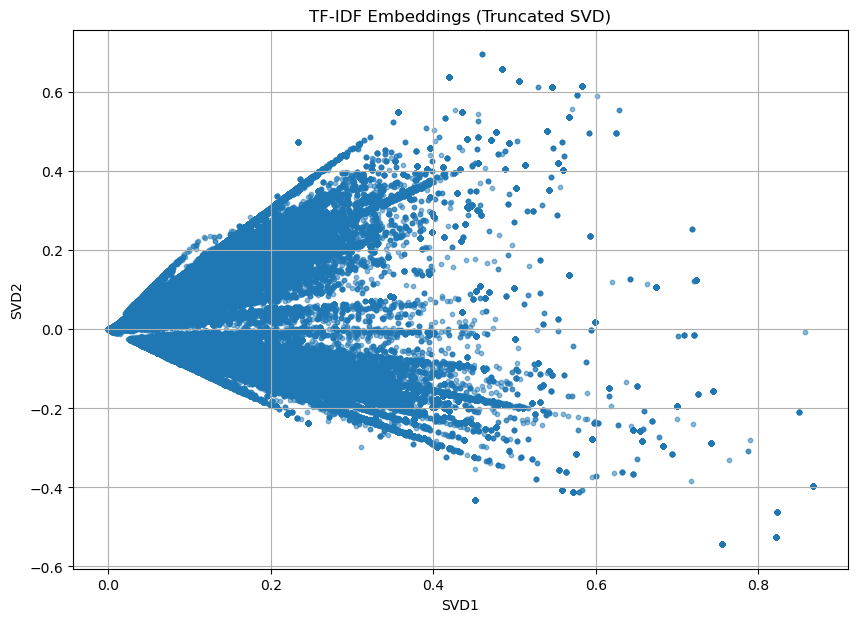

In [40]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd_plot = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd_plot.fit_transform(X_tfidf)

plt.figure(figsize=(10, 7))
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.5, s=10)
plt.title("TF-IDF Embeddings (Truncated SVD)")
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.grid(True)
plt.show()


X_TFIDF has a size (717268, 5000) - this is 3.5 billion elements (if in DENSE format).

After TRUNCATEDSVD (n_components = 100), the size will become (717268, 100) - many times smaller!

In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)


In [42]:
X_reduced.shape

(717268, 100)

In [45]:
import numpy as np
np.save('X_reduced.npy', X_reduced)

#### 3.4 clusterization
Will use combination of k-means and birch


Firstly, create small sample to calibrate params

In [31]:
import numpy as np

np.random.seed(42)

# create small sample for param calibration
sample_size = int(0.05 * len(X_reduced))
sample_idx = np.random.choice(len(X_reduced), size=sample_size, replace=False)
X_sample = X_reduced[sample_idx]

Now choose the best params

Chhose optimal cluster number:
n_clusters=10: Silhouette score = 0.301
n_clusters=15: Silhouette score = 0.328
n_clusters=20: Silhouette score = 0.351
n_clusters=25: Silhouette score = 0.384
n_clusters=30: Silhouette score = 0.391
n_clusters=35: Silhouette score = 0.407
n_clusters=40: Silhouette score = 0.419
n_clusters=45: Silhouette score = 0.416
n_clusters=50: Silhouette score = 0.411


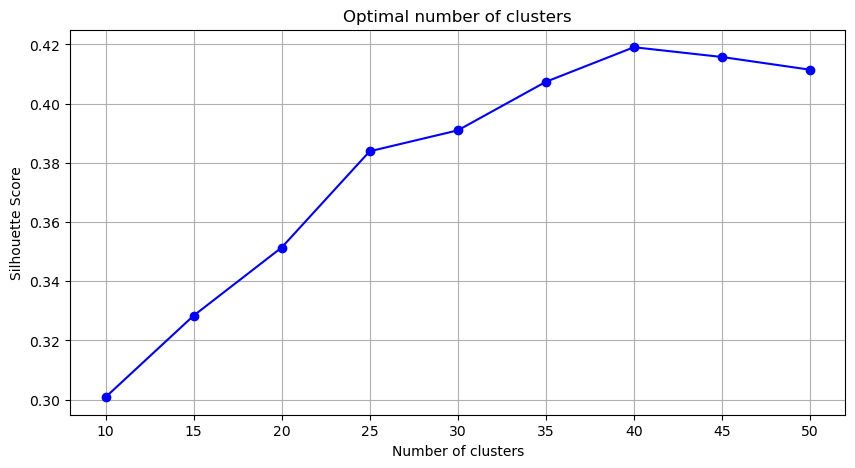


Best result: n_clusters=40 (score=0.419)


In [35]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
cluster_range = range(10, 51, 5)

print("Chhose optimal cluster number:")
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    scores.append(score)
    print(f"n_clusters={n}: Silhouette score = {score:.3f}")

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal number of clusters')
plt.grid(True)
plt.show()

best_n = cluster_range[np.argmax(scores)]
best_score = max(scores)
print(f"\nBest result: n_clusters={best_n} (score={best_score:.3f})")


In [38]:
final_kmeans = KMeans(n_clusters=best_n, random_state=42, n_init=10)
sample_labels = final_kmeans.fit_predict(X_sample)

sample_data = data_combined.iloc[sample_idx].copy()
sample_data['cluster'] = sample_labels

print("\nCluster examples:")
for cluster in sorted(sample_data['cluster'].unique()):
    cluster_jobs = sample_data[sample_data['cluster'] == cluster]['job_title'].values
    cluster_skills = sample_data[sample_data['cluster'] == cluster]['job_skills'].explode().value_counts().head(5)

    print(f"\nCluster {cluster} (size: {len(cluster_jobs)})")
    print("Typical vacancies:")
    print(np.unique(cluster_jobs)[:3])
    print("Top-5 skills:")
    print(cluster_skills)


Cluster examples:

Cluster 0 (size: 248)
Typical vacancies:
['analyst marketing' 'analyst marketing analytics'
 'analyst marketing innovation']
Top-5 skills:
job_skills
sql         147
tableau     101
excel        99
python       97
power bi     60
Name: count, dtype: int64

Cluster 1 (size: 3876)
Typical vacancies:
['1с analyst consultant' '3m data analyst ii san diego ca'
 '4cs4u data analyst cape cod community college']
Top-5 skills:
job_skills
sql         1962
excel       1742
python      1249
tableau     1041
power bi     842
Name: count, dtype: int64

Cluster 2 (size: 1179)
Typical vacancies:
['analytics senior data engineer' 'architecte data senior'
 'bl senior data engineer']
Top-5 skills:
job_skills
python    872
sql       825
aws       552
azure     459
spark     446
Name: count, dtype: int64

Cluster 3 (size: 2302)
Typical vacancies:
['0501wfh data scientist' 'adot data scientist' 'agile1 data scientist']
Top-5 skills:
job_skills
python     1934
sql        1334
r          1

In [36]:
final_kmeans = KMeans(n_clusters=best_n, random_state=42)
data_combined['cluster'] = final_kmeans.fit_predict(X_reduced)

In [37]:
data_combined.head(10)

,job_title,job_skills,normalized_bigrams,cluster
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data],4
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[data engineer, analyst mid, engineer scientis...",10
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[data engineer, analyst principal, engineer le...",14
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[data engineer, engineer sr, jobs sr]",11
5,gcp data engineer,"[python, sql, gcp]","[data engineer, data gcp]",15
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,...","[data senior, data engineer, cloud gcp, engine...",14
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr...",[data engineer],3
8,technology operations business analyst,"[excel, powerpoint, power bi]","[operations technology, analyst business, busi...",34
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,...","[data scientist, ii scientist]",10
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]",[data engineer],3


In [42]:
# save dataframe
data_combined.to_pickle('clustered_vacancies_full.pkl')


In [49]:
import pandas as pd

try:
    data_clustered = pd.read_pickle('clustered_vacancies_full.pkl')
    print("All data successfully downloaded!")
except FileNotFoundError:
    print("No file exists, please do clusterization again :(")

All data successfully downloaded!


#### 3.5 Post-Clusterizarion

In [50]:
cluster_sizes = data_clustered['cluster'].value_counts()
print(cluster_sizes)

cluster
14    160491
3      61968
19     58324
1      47693
4      46386
10     44853
8      23217
20     18576
0      18434
11     17804
13     15656
15     14850
7      13740
12     11213
9      10546
5       9973
33      9799
37      8445
27      8386
18      8259
31      8103
17      8033
21      7967
24      7719
35      7004
16      6895
2       6203
28      5818
38      5469
6       5239
36      5175
25      5148
29      4551
23      4162
22      4022
34      3906
30      3659
32      3615
26      3353
39      2614
Name: count, dtype: int64


##### Too big clusters

If cluster is too big, there is a need to divide it

In [51]:
large_cluster_threshold = 50000
cluster_sizes = data_clustered['cluster'].value_counts()
big_clusters = cluster_sizes[cluster_sizes > large_cluster_threshold].index

for cluster in big_clusters:
    cluster_data = data_clustered[data_clustered['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} records):")
    print("Top-5 vacancies:")
    print(cluster_data['job_title'].value_counts().head(5))
    print("\nTop-10 skills:")
    print(cluster_data['job_skills'].explode().value_counts().head(10))



Cluster 14 (160491 records):
Top-5 vacancies:
job_title
analyst                 884
qa engineer             632
data architect          621
database engineer       551
data quality analyst    498
Name: count, dtype: int64

Top-10 skills:
job_skills
sql         64251
python      53868
excel       27616
aws         23422
azure       21927
tableau     18513
java        17733
spark       15653
power bi    15615
r           14353
Name: count, dtype: int64

Cluster 3 (61968 records):
Top-5 vacancies:
job_title
data engineer          53677
data engineer h f       1389
data engineer m w d      530
data engineer f h        512
data engineer m f d      284
Name: count, dtype: int64

Top-10 skills:
job_skills
sql        44484
python     41611
aws        22598
azure      22576
spark      19599
java       12961
hadoop     10495
kafka      10440
scala      10331
airflow    10273
Name: count, dtype: int64

Cluster 19 (58324 records):
Top-5 vacancies:
job_title
marketing data analyst    970
financial

To identify whether it is worth to divide cluster, let's introduce **diversity** metric

**diversity** = 1 - (frequency of the most popular vacancy / total number of vacancies in a cluster)

* diversity <0.1 → Closure is very homogeneous → Do not divide

* 0.1 ≤ diversity <0.3 → Moderate heterogeneity → Divide optionally

* diversity ≥ 0.3 → Closure is very heterogeneous → It is better to divide

In [52]:
diversity_scores = {}

for cluster in big_clusters:
    titles = data_clustered.loc[data_clustered['cluster'] == cluster, 'job_title']
    most_common = titles.value_counts().iloc[0]
    total = len(titles)
    diversity = 1 - (most_common / total)
    diversity_scores[cluster] = diversity


In [53]:
for cl, score in sorted(diversity_scores.items(), key=lambda x: -x[1]):
    print(f"Cluster {cl}: diversity = {score:.2f}")


Cluster 14: diversity = 0.99
Cluster 19: diversity = 0.98
Cluster 3: diversity = 0.13


In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


def find_best_k(X_cluster, k_min=2, k_max=10):
    best_k = k_min
    best_score = -1

    for k in range(k_min, min(k_max, len(X_cluster)) + 1):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_cluster)

        if len(set(labels)) < 2:
            continue

        score = silhouette_score(X_cluster, labels)
        if score > best_score:
            best_score = score
            best_k = k

    return best_k

for cluster in big_clusters:
    mask = data_clustered['cluster'] == cluster
    X_cluster = X_reduced[mask]

    if len(X_cluster) < 1000:
        continue

    best_k = find_best_k(X_cluster, k_min=2, k_max=min(15, len(X_cluster)//1000))

    print(f"Cluster {cluster} → optimal k = {best_k}")

    kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42)
    sub_labels = kmeans.fit_predict(X_cluster)

    data_clustered.loc[mask, 'cluster'] = sub_labels + (cluster * 100)


In [47]:
cluster_sizes = data_clustered['cluster'].value_counts()
print(cluster_sizes)

cluster
303     61010
1       47693
4       46386
10      44853
1422    38333
        ...  
1903      988
1431      835
1427      747
301       745
308       213
Name: count, Length: 83, dtype: int64


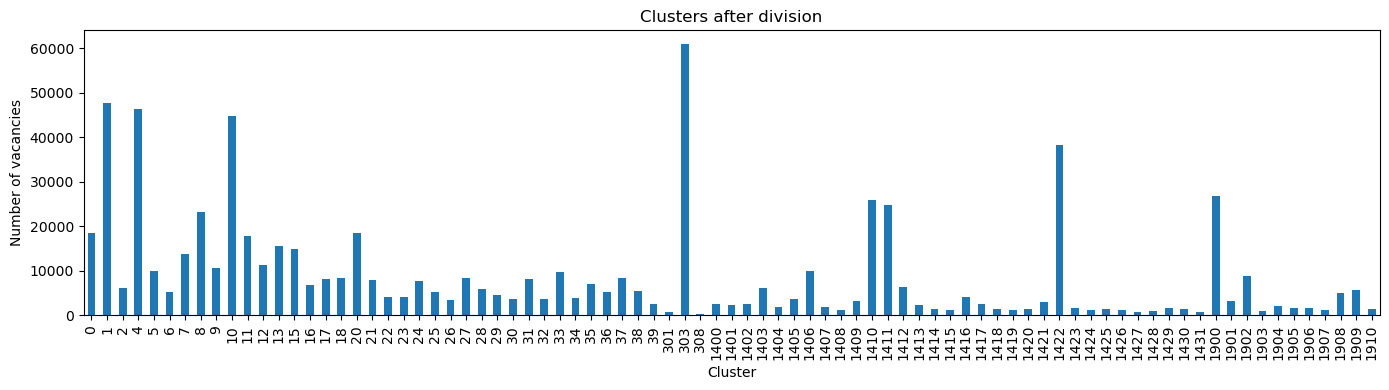

In [48]:
import matplotlib.pyplot as plt
data_clustered['cluster'].value_counts().sort_index().plot(kind='bar', figsize=(14, 4))
plt.title('Clusters after division')
plt.xlabel('Cluster')
plt.ylabel('Number of vacancies')
plt.tight_layout()
plt.show()


In [41]:
#todo: for each cluster choose top-k skills